In [21]:

from __future__ import annotations

import os
import logging
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pypdf
import lancedb
from lancedb.pydantic import LanceModel, Vector
from dotenv import load_dotenv
from google import genai
import logging
from typing import TypedDict, List
from langgraph.graph import StateGraph, END, START
from langchain.schema import Document
import dspy

### Reading from the JD PDFs

In [ ]:
import os
import logging
from pathlib import Path
from typing import List, Dict, Any
import pypdf
from dotenv import load_dotenv

load_dotenv()
LANCE_URI = os.getenv("LANCE_URI")
LANCE_API_KEY = os.getenv("LANCE_API_KEY")
LANCE_REGION = os.getenv("LANCE_REGION")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
DOCS_FOLDER = os.getenv("DOCS_FOLDER", "docs/JD")  # fallback if not set
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY 
os.environ["LANGSMITH_TRACING"] = "true" 

EMBEDDINGS_MODEL_ID = "gemini-embedding-001"

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

llm = dspy.LM("gemini/gemini-2.5-flash", api_key=GEMINI_API_KEY)
dspy.configure(lm=llm)

class RAGState(TypedDict):
    query: str
    docs: List[Document]
    context: str
    answer: str
    plan: dict
    candidate_ids: List[str]
    candidates_context: str     # NEW
    candidate_snippets: List[str]       # aligned 1:1 with candidate_ids  (NEW)
    ranked_ids: List[str]               # reranked
    ranked_scores: List[float]          # reranked similarity scores

def extract_text_from_pdf(pdf_path: Path) -> str:
    """Extract text from a PDF file."""
    try:
        with pdf_path.open("rb") as f:
            reader = pypdf.PdfReader(f)
            text = "\n".join([page.extract_text() or "" for page in reader.pages])
        return text.strip()
    except Exception as e:
        logger.error(f"Error reading {pdf_path}: {e}")
        return ""

def load_job_descriptions(folder: Path) -> List[Dict[str, Any]]:
    """Load all PDFs and return list of job info dictionaries."""
    records = []
    if not folder.exists():
        logger.error(f"❌ Folder {folder} not found")
        return []

    for pdf in sorted(folder.glob("*.pdf")):
        logger.info(f"Processing {pdf.name}...")
        text = extract_text_from_pdf(pdf)
        if not text:
            continue
        records.append({
            "id": f"job_{pdf.stem}",
            "title": pdf.stem.replace("_", " ").replace(" JD", "").strip(),
            "description": text,
            "pdf_path": str(pdf),
            "company": "Unknown",
            "location": "Unknown"
        })
    logger.info(f"📄 Loaded {len(records)} job descriptions.")
    return records

docs_folder = Path(DOCS_FOLDER)
jobs = load_job_descriptions(docs_folder)


INFO:__main__:Processing Associate Software Engineer JD.pdf...
INFO:__main__:Processing Business Development Executive JD.pdf...
INFO:__main__:Processing Entry Level Marketing Associate JD.pdf...
INFO:__main__:📄 Loaded 3 job descriptions.


## Function to reconstruct full documents from the chunks
This works by checking the chunk ID and getting all of the ids

In [23]:
def reconstruct_full_docs(chunks):
    docs_map = {}
    for chunk in chunks:
        doc_id = chunk.metadata['id']
        if doc_id not in docs_map:
            docs_map[doc_id] = []
        docs_map[doc_id].append(chunk.page_content)
    
    return [" ".join(chunks) for chunks in docs_map.values()]

### Chunking

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # max characters per chunk
    chunk_overlap=50   # overlap for context continuity
)

# Convert job descriptions to LangChain Document objects
from langchain.schema import Document
docs = [Document(page_content=j["description"], metadata={"id": j["id"], "title": j["title"]}) for j in jobs]

# Split into chunks
chunks = text_splitter.split_documents(docs)
print(f"✅ Split into {len(chunks)} chunks")


✅ Split into 12 chunks


### Storing to Vector DB

In [25]:
import os
import lancedb
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import LanceDB

db = lancedb.connect(
  uri="db://agentic-hr-a7qydd",
  api_key=LANCE_API_KEY,
  region="us-east-1"
)
print("✅ Connected to LanceDB")

# --- 2. Remove any existing table before re-creating it ---
if "job_descriptions" in db.table_names():
    db.drop_table("job_descriptions")
    print("🧹 Old table 'job_descriptions' removed.")

# --- 3. Create Gemini embedding model ---
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

# --- 4. Insert all chunks (LanceDB infers schema automatically) ---
vector_store = LanceDB.from_documents(
    documents=chunks,         # list of LangChain Document objects
    embedding=embeddings,     # Gemini embedding model
    connection=db,            # the DB connection (not a table)
    table_name="job_descriptions",
    api_key=LANCE_API_KEY,
    region=LANCE_REGION,
    uri=LANCE_URI
)

print(f"✅ Stored {len(chunks)} chunks in 'job_descriptions'")

# --- 5. Verify table structure ---

table = db.open_table("job_descriptions")
print(table.schema)
print("Total rows:", table.count_rows())


✅ Connected to LanceDB
🧹 Old table 'job_descriptions' removed.


E0000 00:00:1761720328.564958    6666 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761720328.566130    6666 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅ Stored 12 chunks in 'job_descriptions'
vector: fixed_size_list<item: float>[3072]
  child 0, item: float
id: string
text: string
metadata: struct<id: string, title: string>
  child 0, id: string
  child 1, title: string
Total rows: 12


In [26]:
from langchain_core.prompts import ChatPromptTemplate

template = """
Give me the Job Description for the position of a Software Engineer
"""

prompt = ChatPromptTemplate.from_template(template)


In [27]:
query = "Tell me about data scientist responsibilities."
query_embedding = embeddings.embed_query(query)
print(f"✅ Query embedding length: {len(query_embedding)}")


✅ Query embedding length: 3072


In [28]:
# Modify the retriever setup
retriever = vector_store.as_retriever(
    search_kwargs={
        "k": 10,  # increase number of chunks retrieved
        "fetch_k": 20  # fetch more candidates before selecting top k
    }
)
# AFTER your existing retriever creation:
GLOBAL_RETRIEVER = retriever   # NEW: expose retriever to graph nodes
docs = retriever.get_relevant_documents(query)
full_docs = reconstruct_full_docs(docs)
print(f"✅ Retrieved {len(docs)} relevant chunks.")

✅ Retrieved 10 relevant chunks.


In [29]:
if full_docs:
    context = full_docs[0]  # Take the first reconstructed document
else:
    context = "No relevant document found."
    

In [30]:
def retrieve_and_process(query: str) -> str:
    docs = retriever.get_relevant_documents(query)
    full_docs = reconstruct_full_docs(docs)
    return full_docs[0] if full_docs else "No relevant document found."



### DSPy Context Engineering + Node Definitions for Retreival and Generation of JD

In [31]:
# NEW: DSPy signature for your task
class AnswerJD(dspy.Signature):
    """Using the provided job description context, answer the user's query clearly and concisely."""
    context: str = dspy.InputField(desc="Reconstructed job description text")
    query: str = dspy.InputField(desc="User query requesting a JD or details")
    answer: str = dspy.OutputField(desc="Final structured answer focused on the most relevant JD")

# NEW: node 1 — retrieve docs using your existing retriever + reconstruct_full_docs
def node_retrieve(state: RAGState) -> dict:
    q = state["query"]
    docs = GLOBAL_RETRIEVER.get_relevant_documents(q)
    full_docs = reconstruct_full_docs(docs)
    context = full_docs[0] if full_docs else "No relevant document found."
    # ✅ Return only what this node changes
    return {"docs": docs, "context": context}

    
def node_generate(state: RAGState) -> dict:
    dspy_module = dspy.Predict(AnswerJD)
    # prefer reranked_context > candidates_context > JD context
    ctx = state.get("reranked_context") or state.get("candidates_context") or state.get("context") or ""
    pred = dspy_module(context=ctx, query=state["query"])
    return {"answer": getattr(pred, "answer", "").strip()}




In [32]:
# NEW: metadata ingest — place after you create `db`
import json
from pathlib import Path

CAND_TABLE = "candidates_meta"
META_JSON_DIR = Path("/home/ahmad-faisal/lang/HR/docs/Resumes/metadata")  # put your 12 JSONs here

def load_meta_docs(meta_dir: Path) -> list[Document]:
    docs = []
    for p in sorted(meta_dir.glob("*.json")):
        with p.open("r", encoding="utf-8") as f:
            j = json.load(f)
        # compact text field purely from metadata we actually have
        text = " | ".join([
            str(j.get("job_title", "")).strip(),
            str(j.get("university", "")).strip(),
            str(j.get("candidate_name", "")).strip(),
            str(j.get("doc_type", "")).strip(),
            str(j.get("source", "")).strip(),
        ])
        docs.append(Document(
            page_content=text,
            metadata={
                "resume_id": str(j.get("id", "")).strip(),
                "candidate_name": str(j.get("candidate_name", "")).strip(),
                "university": str(j.get("university", "")).strip(),
                "job_title": str(j.get("job_title", "")).strip(),
                "doc_type": str(j.get("doc_type", "")).strip(),
                "source": str(j.get("source", "")).strip(),
            }
        ))
    return docs

meta_docs = load_meta_docs(META_JSON_DIR)

# (Re)create the vector table; schema is inferred with a vector column
if CAND_TABLE in db.table_names():
    db.drop_table(CAND_TABLE)

cand_vs = LanceDB.from_documents(
    documents=meta_docs,
    embedding=embeddings,     # your existing GoogleGenerativeAIEmbeddings
    connection=db,
    table_name=CAND_TABLE,
    mode="overwrite",
    api_key=LANCE_API_KEY,
    region=LANCE_REGION,
    uri=LANCE_URI
)

In [33]:
def _quote(vals):
    # simple SQL-ish quoting for where clause
    return ", ".join(repr(str(v)) for v in vals if v is not None and str(v) != "")

def build_candidates_context(resume_ids: list[str], *, db, table_name: str = CAND_TABLE) -> str:
    if not resume_ids:
        return "No candidate IDs to display."

    tbl = db.open_table(table_name)

    # IMPORTANT: nested struct paths in LanceDB filters use dot notation
    id_filter = f"metadata.resume_id IN ({_quote(resume_ids)})"

    # Select only nested fields we need; dot paths are allowed
    rows = (
        tbl.search()
           .where(id_filter)
           .select([
               "metadata.candidate_name",
               "metadata.job_title",
               "metadata.university",
               "metadata.resume_id",
           ])
           .limit(len(resume_ids))
           .to_list()
    )

    # Depending on driver version, rows may come back nested under 'metadata'
    # or as flat keys with dots. Handle both safely:
    lines = []
    for r in rows:
        md = r.get("metadata") or {}
        # fallback if keys are flattened like "metadata.candidate_name"
        name = md.get("candidate_name") or r.get("metadata.candidate_name", "") or ""
        title = md.get("job_title") or r.get("metadata.job_title", "") or ""
        uni   = md.get("university") or r.get("metadata.university", "") or ""
        rid   = md.get("resume_id") or r.get("metadata.resume_id", "") or ""
        lines.append(f"- {name.strip()} | {title.strip()} | {uni.strip()} | id={str(rid).strip()}")

    return "\n".join(lines[:100]) if lines else "No matching candidates found."


In [34]:
def node_plan_from_jd(state: RAGState) -> dict:
    jd_text = state.get("context") or ""
    plan = {
        "jd_embedding": embeddings.embed_query(jd_text),
        "k_candidates": 2,
        "indexes": ["candidates_meta"],
    }
    # ✅ Only plan
    return {"plan": plan}


In [ ]:
def node_pool_candidates(state: "RAGState") -> dict:
    plan = state["plan"]
    k = int(plan.get("k_candidates", 100))
    jd_vec = plan["jd_embedding"]

    cand_store = LanceDB(connection=db, embedding=embeddings, table_name=CAND_TABLE)
    hits = cand_store.similarity_search_by_vector(jd_vec, k=k)

    # Build context right from hits (no DB WHERE on resume_id)
    lines, ids = [], []
    for h in hits:
        md = h.metadata or {}
        rid = str(md.get("resume_id", "")).strip()
        name = (md.get("candidate_name") or "").strip()
        title = (md.get("job_title") or "").strip()
        uni = (md.get("university") or "").strip()
        ids.append(rid or f"{name}|{title}")  # fallback stable key if resume_id missing
        lines.append(f"- {name} | {title} | {uni} | id={rid or 'n/a'}")

    return {
        "candidate_ids": ids,
        "candidates_context": "\n".join(lines[:100]) if lines else "No matching candidates found."
    }


In [37]:
def has_context(state):
    return state.get("context") and state["context"] != "No relevant document found."

### Graph definition

In [ ]:
# NEW: build a simple 2-node graph
graph = StateGraph(RAGState)
graph.add_node("retrieve", node_retrieve)
graph.add_node("plan_from_jd", node_plan_from_jd)
graph.add_node("pool_candidates", node_pool_candidates)
graph.add_node("generate", node_generate)

graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "plan_from_jd")
graph.add_edge("plan_from_jd", "pool_candidates")
graph.add_edge("pool_candidates", "generate")
graph.add_edge("generate", END)

app = graph.compile()


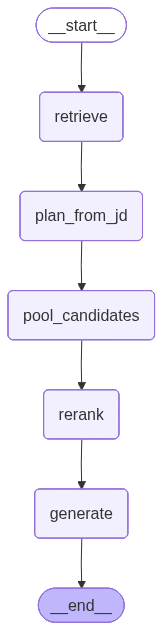

In [39]:
app

In [40]:
# NEW: LangGraph run
result_state = app.invoke({"query": "Give me the best candidate for the position of a business executive."})
print("\n🧩 Final Answer:\n", result_state["answer"])


AttributeError: 'LanceEmptyQueryBuilder' object has no attribute 'nearest'